In [12]:
!python --version

Python 3.13.2


In [23]:
!python -m pip install opencv-python

   ---------------------------------------- 0.0/39.0 MB ? eta -:--:--
   ------ --------------------------------- 6.6/39.0 MB 32.6 MB/s eta 0:00:01
   ------------- -------------------------- 13.6/39.0 MB 33.5 MB/s eta 0:00:01
   ------------------- -------------------- 19.4/39.0 MB 31.6 MB/s eta 0:00:01
   ------------------------ --------------- 23.6/39.0 MB 29.0 MB/s eta 0:00:01
   ---------------------------- ----------- 28.0/39.0 MB 27.6 MB/s eta 0:00:01
   --------------------------------- ------ 32.5/39.0 MB 26.7 MB/s eta 0:00:01
   -------------------------------------- - 37.5/39.0 MB 26.2 MB/s eta 0:00:01
   ---------------------------------------- 39.0/39.0 MB 25.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:

import json
import os
from collections import defaultdict
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [26]:
import zipfile
import os

zip_path = 'chessred2k.zip'  
extract_to = '.'  

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}")

Extracted chessred2k.zip to .


In [43]:
data_dir = './images'
ad = './json/annotations.json'
with open(ad, "r") as f:
            annotations = json.load(f)

In [44]:
# messing around with annotations.json

print(annotations.keys(), "\n")
print(annotations['categories'], "\n") # id map for each type of piece

print(annotations['splits']['chessred2k']['train'])
print(annotations['splits']['chessred2k']['val'])
print(annotations['splits']['chessred2k']['test'])

print(annotations['annotations']['pieces'][0]) # all 223,804 piece annotations for 10800 images
print(annotations['annotations']['corners'][0])

print(annotations['images'][0])

dict_keys(['info', 'images', 'annotations', 'categories', 'splits']) 

[{'id': 0, 'name': 'white-pawn'}, {'id': 1, 'name': 'white-rook'}, {'id': 2, 'name': 'white-knight'}, {'id': 3, 'name': 'white-bishop'}, {'id': 4, 'name': 'white-queen'}, {'id': 5, 'name': 'white-king'}, {'id': 6, 'name': 'black-pawn'}, {'id': 7, 'name': 'black-rook'}, {'id': 8, 'name': 'black-knight'}, {'id': 9, 'name': 'black-bishop'}, {'id': 10, 'name': 'black-queen'}, {'id': 11, 'name': 'black-king'}, {'id': 12, 'name': 'empty'}] 

{'image_ids': [2383, 2384, 2385, 2386, 2387, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455, 2456, 2457, 2458, 2459, 2460, 2461, 

In [45]:
image_id_to_path = {img['id']: os.path.join(data_dir, img['path']) for img in annotations['images']}
print(image_id_to_path)

image_to_pieces = defaultdict(list)
for ann in annotations['annotations']['pieces']:
    image_to_pieces[ann['image_id']].append(ann)
print(image_to_pieces[0])

{0: './images\\images/0/G000_IMG000.jpg', 1: './images\\images/0/G000_IMG001.jpg', 2: './images\\images/0/G000_IMG002.jpg', 3: './images\\images/0/G000_IMG003.jpg', 4: './images\\images/0/G000_IMG004.jpg', 5: './images\\images/0/G000_IMG005.jpg', 6: './images\\images/0/G000_IMG006.jpg', 7: './images\\images/0/G000_IMG007.jpg', 8: './images\\images/0/G000_IMG008.jpg', 9: './images\\images/0/G000_IMG009.jpg', 10: './images\\images/0/G000_IMG010.jpg', 11: './images\\images/0/G000_IMG011.jpg', 12: './images\\images/0/G000_IMG012.jpg', 13: './images\\images/0/G000_IMG013.jpg', 14: './images\\images/0/G000_IMG014.jpg', 15: './images\\images/0/G000_IMG015.jpg', 16: './images\\images/0/G000_IMG016.jpg', 17: './images\\images/0/G000_IMG017.jpg', 18: './images\\images/0/G000_IMG018.jpg', 19: './images\\images/0/G000_IMG019.jpg', 20: './images\\images/0/G000_IMG020.jpg', 21: './images\\images/0/G000_IMG021.jpg', 22: './images\\images/0/G000_IMG022.jpg', 23: './images\\images/0/G000_IMG023.jpg', 2

In [46]:
id_to_piece = {
    0: 'P', 1: 'R', 2: 'N', 3: 'B', 4: 'Q', 5: 'K',
    6: 'p', 7: 'r', 8: 'n', 9: 'b', 10: 'q', 11: 'k',
    12: '1' 
}

piece_to_label = {
    'P': 0, 'R': 1, 'N': 2, 'B': 3, 'Q': 4, 'K': 5,
    'p': 6, 'r': 7, 'n': 8, 'b': 9, 'q': 10, 'k': 11
}

def fen_to_label_vector(fen):
    squares = []
    for row in fen.split('/'):
        for ch in row:
            if ch.isdigit():
                squares.append(12)
            else:
                squares.append(piece_to_label[ch])
    return torch.tensor(squares, dtype=torch.long)  

def pieces_to_fen(piece_list):
    board = [['1'] * 8 for _ in range(8)]
    pos_to_index = lambda pos: (8 - int(pos[1]), ord(pos[0]) - ord('a'))

    for piece in piece_list:
        row, col = pos_to_index(piece['chessboard_position'])
        board[row][col] = id_to_piece[piece['category_id']]

    fen_rows = []
    for row in board:
        fen_row = ''
        count = 0
        for cell in row:
            if cell == '1':
                fen_row += '0'
            else:
                fen_row += cell
        fen_rows.append(fen_row)

    return '/'.join(fen_rows)

print(pieces_to_fen(image_to_pieces[10]))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])))
print(fen_to_label_vector(pieces_to_fen(image_to_pieces[10])).shape)

r00qkb0r/pppn0ppp/0000pn00/000p0b00/0P000000/P000PN00/0BPP0PPP/RN0QKB0R
tensor([ 7, 12, 12, 10, 11,  9, 12,  7,  6,  6,  6,  8, 12,  6,  6,  6, 12, 12,
        12, 12,  6,  8, 12, 12, 12, 12, 12,  6, 12,  9, 12, 12, 12,  0, 12, 12,
        12, 12, 12, 12,  0, 12, 12, 12,  0,  2, 12, 12, 12,  3,  0,  0, 12,  0,
         0,  0,  1,  2, 12,  4,  5,  3, 12,  1])
torch.Size([64])


In [48]:
data_transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      ])


# dataset class to be used by DataLoader. Needs init, len, getitem functions
class ChessFENDataset(Dataset):
    def __init__(self, image_ids, image_to_pieces, image_id_to_path, transform=None):
        self.image_ids = image_ids
        self.image_to_pieces = image_to_pieces
        self.image_id_to_path = image_id_to_path
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = self.image_id_to_path[image_id]
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        piece_list = self.image_to_pieces[image_id]
        fen = pieces_to_fen(piece_list)
        label = fen_to_label_vector(fen)
        return image, label


In [49]:
train_ids = annotations['splits']['chessred2k']['train']['image_ids']
train_dataset = ChessFENDataset(train_ids, image_to_pieces, image_id_to_path)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Training Images: {len(train_dataset)}")

val_ids = annotations['splits']['chessred2k']['val']['image_ids']
val_dataset = ChessFENDataset(val_ids, image_to_pieces, image_id_to_path)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Validation Images: {len(val_dataset)}")

test_ids = annotations['splits']['chessred2k']['test']['image_ids']
test_dataset = ChessFENDataset(test_ids, image_to_pieces, image_id_to_path)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"ChessReD2K Testing Images: {len(test_dataset)}")


ChessReD2K Training Images: 1442
ChessReD2K Validation Images: 330
ChessReD2K Testing Images: 306


In [83]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_edges(img, low=50, high=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, low, high)
    # close small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    return cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

def detect_hough_lines_p(edges, 
                         rho=1, theta=np.pi/180, threshold=100, 
                         min_len=100, max_gap=10):
    raw = cv2.HoughLinesP(edges, rho, theta, threshold, 
                          minLineLength=min_len, maxLineGap=max_gap)
    if raw is None:
        return []
    # convert to (rho,theta) form for compatibility
    lines = []
    for x1,y1,x2,y2 in raw[:,0]:
        # compute [rho,theta]
        dx,dy = x2-x1, y2-y1
        theta = np.arctan2(dy, dx)
        rho = x1*np.cos(theta) + y1*np.sin(theta)
        lines.append((rho, theta))
    return lines

def split_and_sort(lines):
    vert, hor = [], []
    for rho,theta in lines:
        if abs(np.sin(theta)) < abs(np.cos(theta)):
            vert.append((rho,theta))
        else:
            hor.append((rho,theta))
    # sort by intercept
    vert = sorted(vert, key=lambda rt: rt[0]/np.cos(rt[1]))
    hor  = sorted(hor,  key=lambda rt: rt[0]/np.sin(rt[1]))
    return vert, hor

def intersect(l1, l2):
    (r1,t1),(r2,t2) = l1,l2
    A = np.array([[np.cos(t1), np.sin(t1)],
                  [np.cos(t2), np.sin(t2)]])
    b = np.array([r1, r2])
    return np.linalg.solve(A, b)

def warp_and_crop_board(img):
    h,w = img.shape[:2]

    # 1) edges + closing
    edges = detect_edges(img)

    # 2) probabilistic Hough
    lines = detect_hough_lines_p(edges, threshold=150, min_len=w//4)

    # 3) cluster & sort
    v_lines, h_lines = split_and_sort(lines)
    if len(v_lines)<2 or len(h_lines)<2:
        raise RuntimeError("Couldn't find enough grid lines")

    # 4) find 4 corner points
    top_left     = intersect(v_lines[0],    h_lines[0])
    top_right    = intersect(v_lines[-1],   h_lines[0])
    bottom_right = intersect(v_lines[-1],   h_lines[-1])
    bottom_left  = intersect(v_lines[0],    h_lines[-1])
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)

    # 5) compute board size in pixels
    width  = np.linalg.norm(top_right - top_left)
    height = np.linalg.norm(bottom_left - top_left)
    dst = np.array([[0,0], [width,0], [width,height], [0,height]], dtype=np.float32)

    # 6) homography & warp
    H = cv2.getPerspectiveTransform(src, dst)
    board = cv2.warpPerspective(img, H, (int(width), int(height)))

    return edges, board

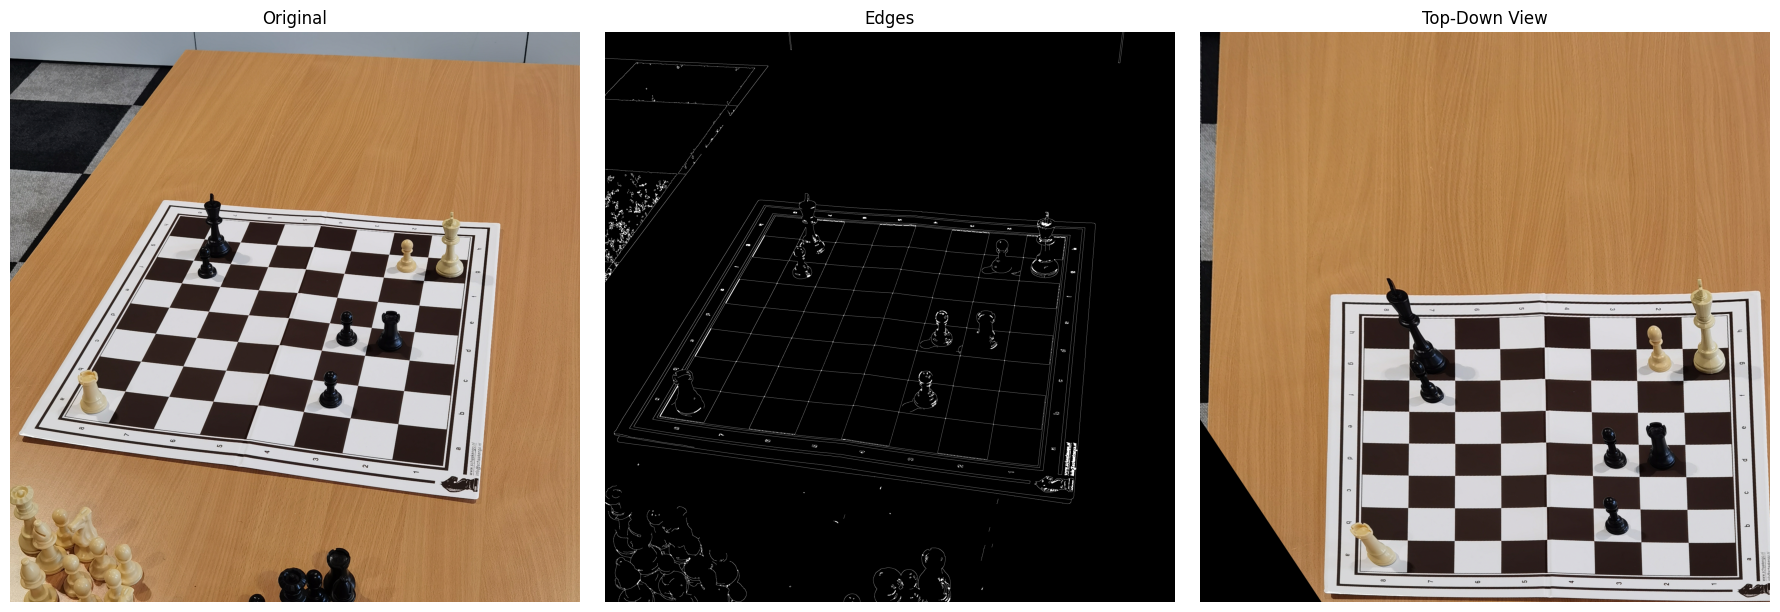

In [84]:

img_path = './images/0/G000_IMG101.jpg'  
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {img_path}")

edges, topdown = warp_board_topdown(img)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Edges"); axes[1].axis("off")
axes[2].imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
axes[2].set_title("Top-Down View"); axes[2].axis("off")
plt.tight_layout()
plt.show()

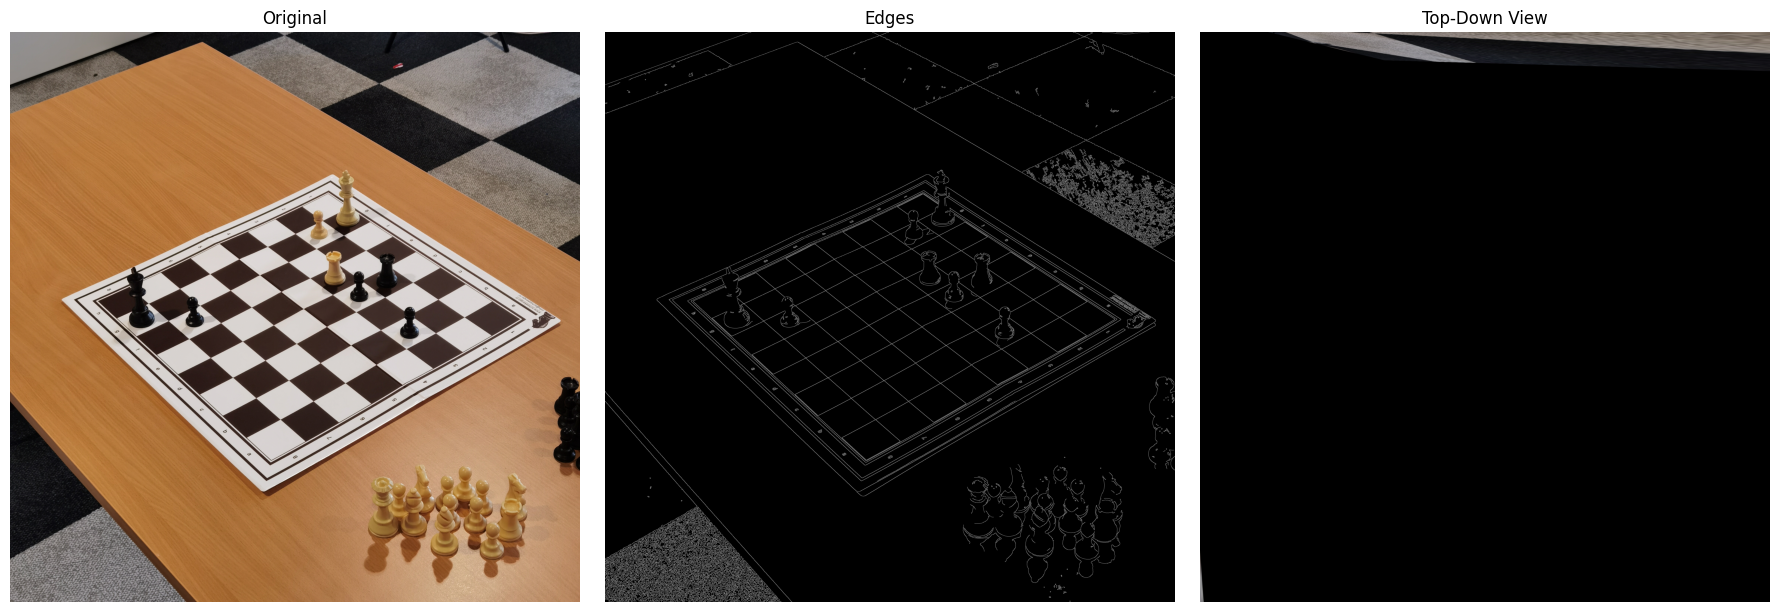

In [ ]:

img_path = './images/0/G000_IMG098.jpg'  
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {img_path}")

edges, topdown = warp_board_topdown(img)

# Display results
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original"); axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Edges"); axes[1].axis("off")
axes[2].imshow(cv2.cvtColor(topdown, cv2.COLOR_BGR2RGB))
axes[2].set_title("Top-Down View"); axes[2].axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np

def detect_edges(img, low=50, high=150):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, low, high)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    return cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

def detect_hough_lines_p(edges, rho=1, theta=np.pi/180, threshold=150, min_len=100, max_gap=10):
    raw = cv2.HoughLinesP(edges, rho, theta, threshold,
                          minLineLength=min_len, maxLineGap=max_gap)
    if raw is None:
        return []
    lines = []
    for x1,y1,x2,y2 in raw[:,0]:
        dx, dy = x2-x1, y2-y1
        theta = np.arctan2(dy, dx)
        rho   = x1*np.cos(theta) + y1*np.sin(theta)
        lines.append((rho, theta))
    return lines

def split_and_sort(lines):
    vert, hor = [], []
    for rho,theta in lines:
        if abs(np.sin(theta)) < abs(np.cos(theta)):
            vert.append((rho,theta))
        else:
            hor.append((rho,theta))
    vert = sorted(vert, key=lambda rt: rt[0]/np.cos(rt[1]))
    hor  = sorted(hor,  key=lambda rt: rt[0]/np.sin(rt[1]))
    return vert, hor

def intersect(l1, l2):
    (r1,t1),(r2,t2) = l1,l2
    A = np.array([[np.cos(t1), np.sin(t1)],
                  [np.cos(t2), np.sin(t2)]])
    b = np.array([r1, r2])
    return np.linalg.solve(A, b)

def order_quad(pts):
    pts = np.array(pts, dtype=np.float32)
    s = pts.sum(axis=1)
    tl = pts[np.argmin(s)]
    br = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    tr = pts[np.argmin(diff)]
    bl = pts[np.argmax(diff)]
    return np.vstack([tl, tr, br, bl]).astype(np.float32)

def contour_fallback_from_edges(edges):
    cnts, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    best = None
    max_area = 0
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx)==4:
            area = cv2.contourArea(approx)
            if area > max_area:
                max_area = area
                best = approx.reshape(4,2)
    if best is None:
        raise RuntimeError("Contour fallback failed")
    return order_quad(best)

def warp_and_crop_board(img):
    h, w = img.shape[:2]
    edges = detect_edges(img)

    src = None
    try:
        lines = detect_hough_lines_p(edges,
                                     threshold=max(50, w//8),
                                     min_len=w//4)
        v_lines, h_lines = split_and_sort(lines)
        if len(v_lines)>=2 and len(h_lines)>=2:
            tl = intersect(v_lines[0],    h_lines[0])
            tr = intersect(v_lines[-1],   h_lines[0])
            br = intersect(v_lines[-1],   h_lines[-1])
            bl = intersect(v_lines[0],    h_lines[-1])
            src = order_quad([tl, tr, br, bl])
    except Exception:
        src = None

    if src is None:
        src = contour_fallback_from_edges(edges)

    tl, tr, br, bl = src
    width  = np.linalg.norm(tr - tl)
    height = np.linalg.norm(bl - tl)
    W, H = int(round(width)), int(round(height))
    dst = np.array([[0, 0], [W-1, 0], [W-1, H-1], [0, H-1]],
                   dtype=np.float32)

    M = cv2.getPerspectiveTransform(src, dst)
    board = cv2.warpPerspective(img, M, (W, H))

    return edges, board


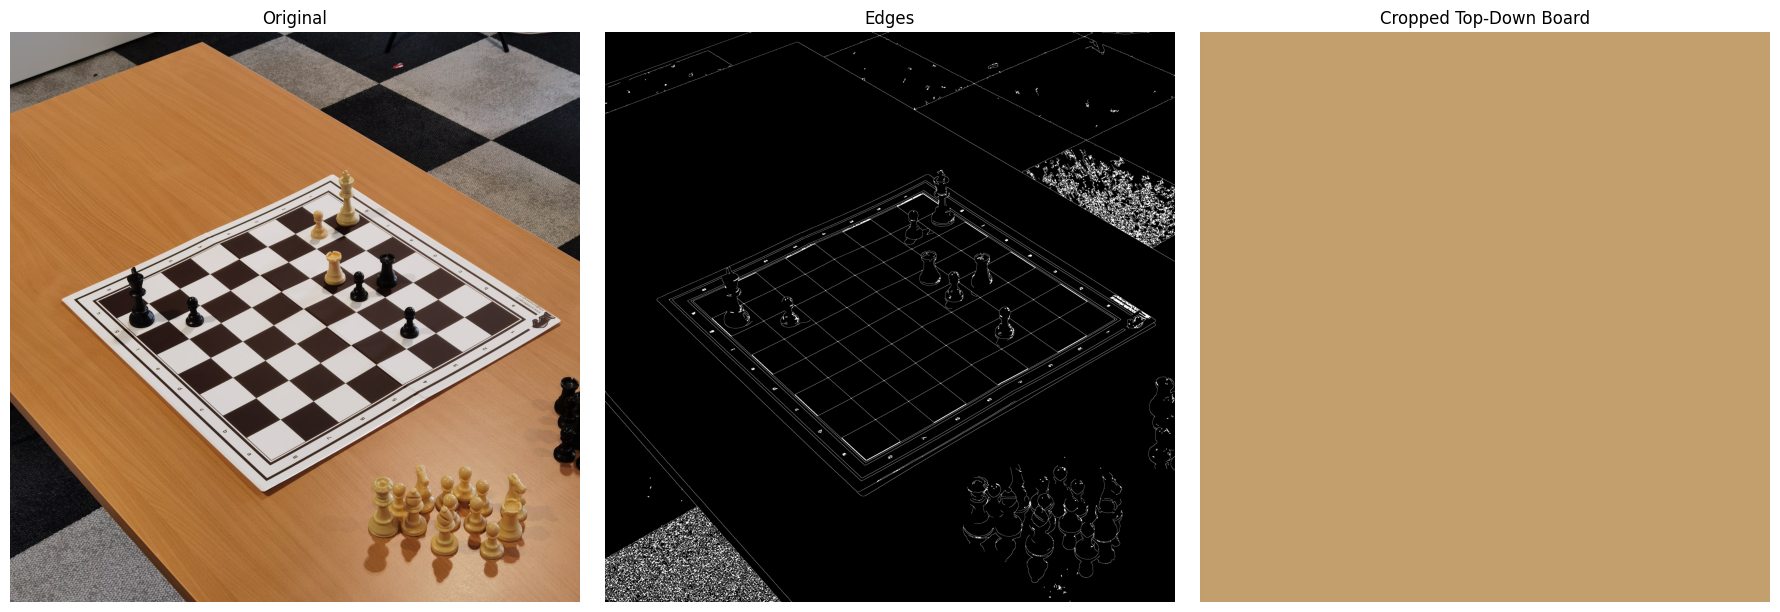

In [96]:

img_path = './images/0/G000_IMG098.jpg'
img = cv2.imread(img_path)
if img is None:
    raise FileNotFoundError(f"Cannot load image at {img_path}")
edges, board = warp_and_crop_board(img)
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original")
axes[0].axis("off")
axes[1].imshow(edges, cmap="gray")
axes[1].set_title("Edges")
axes[1].axis("off")
axes[2].imshow(cv2.cvtColor(board, cv2.COLOR_BGR2RGB))
axes[2].set_title("Cropped Top-Down Board")
axes[2].axis("off")
plt.tight_layout()
plt.show()

